In [69]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Download datset

In [70]:
ROOT_DATA_DIR='FashionMNISTDir'

train_data = datasets.FashionMNIST(
    root = ROOT_DATA_DIR,
    train=True,
    download=True,
    transform = transforms.ToTensor()
)

test_data = datasets.FashionMNIST(
    root =ROOT_DATA_DIR,
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

In [71]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [72]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [73]:
label_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3:' Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot',
    }

# Visualize One Example

In [74]:
def view_image(data, index, label_map):
  plt.imshow(data.data[index], cmap='gray')
  plt.title(f"data label: {label_map[data.targets[index].item()]}")
  plt.axis("off")

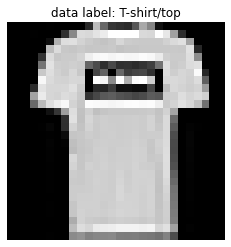

In [75]:
view_image(train_data, index=1, label_map=label_map)

# Create dataloader

In [76]:
BATCH_SIZE=64

train_data_loader = DataLoader(
    dataset = train_data,
    batch_size = BATCH_SIZE,
    shuffle=True
)

test_data_loader = DataLoader(
    dataset = test_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [77]:
for data, label in test_data_loader:
  print(data.shape)
  print(label.shape)
  break

torch.Size([64, 1, 28, 28])
torch.Size([64])


# Cnn Architecture

In [78]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [79]:
class CNN(nn.Module):
  def __init__(self, in_, out_):
    super(CNN, self).__init__()

    self.conv_pool_01 = nn.Sequential(
        nn.Conv2d(in_channels=in_, out_channels = 8, kernel_size=5, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv_pool_02 = nn.Sequential(
        nn.Conv2d(in_channels = 8, out_channels=16, kernel_size=5, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.Flatten = nn.Flatten()
    self.FC_01 = nn.Linear(in_features=16*4*4, out_features=128)
    self.FC_02 = nn.Linear(in_features=128, out_features=64)
    self.FC_03 = nn.Linear(in_features=64, out_features = out_)

  def forward(self, x):
    x = self.conv_pool_01(x)
    x = self.conv_pool_02(x)
    x = self.Flatten(x)
    x = self.FC_01(x)
    x = self.FC_02(x)        
    x = self.FC_03(x)
    return x

In [80]:
model = CNN(1, 10)
model.to(device)

CNN(
  (conv_pool_01): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_pool_02): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (FC_01): Linear(in_features=256, out_features=128, bias=True)
  (FC_02): Linear(in_features=128, out_features=64, bias=True)
  (FC_03): Linear(in_features=64, out_features=10, bias=True)
)

#Count no of trainable parameters

In [81]:
def count_params(model):
  model_params  = {'Modules': list(), 'Parameters': list()}
  total = 0
  for name, parameters in model.named_parameters():
    if not parameters.requires_grad:
      continue
    params = parameters.numel()
    model_params['Modules'].append(name)
    model_params['Parameters'].append(params)
    total+=params
  df = pd.DataFrame(model_params)
  df = df.style.set_caption(f'Total trainable parameters: {total}')
  return df

count_params(model)

,Modules,Parameters
0,conv_pool_01.0.weight,200
1,conv_pool_01.0.bias,8
2,conv_pool_02.0.weight,3200
3,conv_pool_02.0.bias,16
4,FC_01.weight,32768
5,FC_01.bias,128
6,FC_02.weight,8192
7,FC_02.bias,64
8,FC_03.weight,640
9,FC_03.bias,10


In [82]:
next(model.parameters()).is_cuda

True

# Training

In [87]:
learning_rate = 0.001
num_epochs = 20

In [88]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [89]:
n_total_steps = len(train_data_loader)
n_total_steps

938

In [90]:
for epoch in range(num_epochs):
  with tqdm(train_data_loader) as tqdm_epoch:
    for images, labels in tqdm_epoch:
      tqdm_epoch.set_description(f"Epoch {epoch+1}/{num_epochs}")

      images = images.to(device)
      labels = labels.to(device)

      # forwards pass
      outputs = model(images)
      loss = criterion(outputs, labels)

      # backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      tqdm_epoch.set_postfix(loss=loss.item())

Epoch 20/20: 100%|██████████| 938/938 [00:15<00:00, 60.26it/s, loss=0.244]


In [91]:
## save trained model -
os.makedirs("CNN", exist_ok=True)
model_file = os.path.join("CNN", 'CNN_model.pth')
torch.save(model, model_file)